L'objectif est de prévoir le temps de retard prévu pour les trains en retard au départ. On veut pouvoir dire aux utilisateurs à combien de retard ils peuvent s'attendre à l'arrivée pour qu'ils s'organisent en conséquence. Cela permet aussi à la SNCF d'anticiper s'il y a des correspondances. 

On retient donc pour features : mois, service, gare départ, gare arrivée, duree du trajet, nb trains prévus, nb_trains_retard_depart, retards_moyen_départ. On ajoute également les données des retards des 3 mois précédents le mois d'étude.  

On se permet de prendre nb_trains_retard_depart et retard_moyen_depart du mois d'étude. On pourrait imaginer enbtrainer un autre modèle pour prédire le nombre de retards du moi en ayant la date et le nombre de retards du mois jusqu'à le date d'étude.  

On considère que les trains en retard au départ sont en retard à l'arrivée donc on cherche à prédire retards_moyen.  

In [42]:
#Cellule d'importation

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor

In [43]:

data = pd.read_csv('../dataset/regularite-mensuelle-tgv-aqst.csv')
df = pd.DataFrame(data)

#On ajoute un colonne année 
annee = []
mois = []
for i in df['date'].values :
    annee.append(int(i[:4]))
    mois.append(int(i[5:]))

df['annee'] = annee
df['mois'] = mois

#On supprime la colonne date

df = df.drop(['date'], axis = 1)

#On ajoute une colonne "retards_moy_arrivee_trajet_passés"

def retards_moyens(df):
    df["retards_moy_arrivee_trajet_passés"] = 0.0
    for i,row in df.iterrows():
        df.loc[i, "retards_moy_arrivee_trajet_passés" ] = df[(df['annee'] <= row['annee']) & (df['gare_depart']== row['gare_depart']) & (df['gare_arrivee']== row['gare_arrivee']) & (df['mois'] <= row['mois'])]["retard_moyen_arrivee"].mean()
    return df

b = retards_moyens(df)

#On transforme la colonne commentaire, si un commentaire est présent, on met un 1, sinon un 0. Les commentaires signifie en général des éléments extraordinaire qui peuvent augmenter les retards.
def comm(com):
    if pd.isna(com): 
        return 0
    else :
        return 1
    
#On fait la transformation
df.loc[:, 'commentaires_retard_arrivee'] = df['commentaires_retard_arrivee'].apply(comm)


#On crée la fonction qui permet d'ajouter les valeurs des retards des mois précédents

def add_delays_previous_months(df, n_months):
    past_month_cols = [f"retards_moys_mois_n-{i}" for i in range(1, n_months+1)]
    for col in past_month_cols:
        df[col] = 0.0
    for i,row in df.iterrows():
        if i%500 == 0:
            print(i)
        annee, mois = row["annee"], row["mois"]
        gare_depart, gare_arrivee = row["gare_depart"], row["gare_arrivee"]
        for j, col_name in enumerate(past_month_cols):
            n_mois_a_soustraire = j+1
            date_mois_prec = (annee, mois-n_mois_a_soustraire) if mois>=n_mois_a_soustraire+1 else ((annee-1, 12+mois-n_mois_a_soustraire) if annee>=2019 else (annee, mois))
            # print((annee, mois), n_mois_a_soustraire, date_mois_prec)
            series = df.loc[(df.gare_depart == gare_depart) & (df.gare_arrivee == gare_arrivee) & (df.annee == date_mois_prec[0]) & (df.mois == date_mois_prec[1]), "retard_moyen_arrivee"]
            # print(series)
            if not series.empty:
                value = series.values[0]
                # print(value)
                df.loc[i, col_name] = value
            else:
                # un peu brutal de prendre la moyenne totale direct : on pourrait essayer le mois d'avant encore ou l'année d'avant...
                df.loc[i, col_name] = row["retards_moy_arrivee_trajet_passés"]
    return df







In [44]:
#On ajoute les données des 3 mois précédents et on affiche le dataframe 

a = add_delays_previous_months(df, 4 )
print(a)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
       service         gare_depart         gare_arrivee  duree_moyenne  \
0     National    BORDEAUX ST JEAN   PARIS MONTPARNASSE            141   
1     National   LA ROCHELLE VILLE   PARIS MONTPARNASSE            165   
2     National  PARIS MONTPARNASSE              QUIMPER            220   
3     National  PARIS MONTPARNASSE              ST MALO            156   
4     National  PARIS MONTPARNASSE  ST PIERRE DES CORPS             61   
...        ...                 ...                  ...            ...   
8149  National          STRASBOURG            PARIS EST            114   
8150  National   TOULOUSE MATABIAU   PARIS MONTPARNASSE            273   
8151  National               TOURS   PARIS MONTPARNASSE             78   
8152  National  VALENCE ALIXAN TGV           PARIS LYON            133   
8153  National              VANNES   PARIS MONTPARNASSE            167   

      nb_train_prevu  nb_annul

In [45]:
#On enlève les données des quatre premiers mois du dataset où les valeurs des mois précédents n'existe pas. Ces lignes viennent fausser la donnée.

a = a.drop(a[(a['mois'] == 1) & (a['annee'] == 2018)].index)
a = a.drop(a[(a['mois'] == 2) & (a['annee'] == 2018)].index)
a = a.drop(a[(a['mois'] == 3) & (a['annee'] == 2018)].index)
a = a.drop(a[(a['mois'] == 4) & (a['annee'] == 2018)].index)

print(a)

       service         gare_depart        gare_arrivee  duree_moyenne  \
520   National  PARIS MONTPARNASSE    BORDEAUX ST JEAN            140   
521   National    BORDEAUX ST JEAN  PARIS MONTPARNASSE            140   
522   National               BREST  PARIS MONTPARNASSE            226   
523   National  PARIS MONTPARNASSE   LA ROCHELLE VILLE            167   
524   National   LA ROCHELLE VILLE  PARIS MONTPARNASSE            165   
...        ...                 ...                 ...            ...   
8149  National          STRASBOURG           PARIS EST            114   
8150  National   TOULOUSE MATABIAU  PARIS MONTPARNASSE            273   
8151  National               TOURS  PARIS MONTPARNASSE             78   
8152  National  VALENCE ALIXAN TGV          PARIS LYON            133   
8153  National              VANNES  PARIS MONTPARNASSE            167   

      nb_train_prevu  nb_annulation  commentaire_annulation  \
520              800            266                     NaN 

Text(0.5, 1.0, 'Features Correlating with retard_moyen_arrivee')

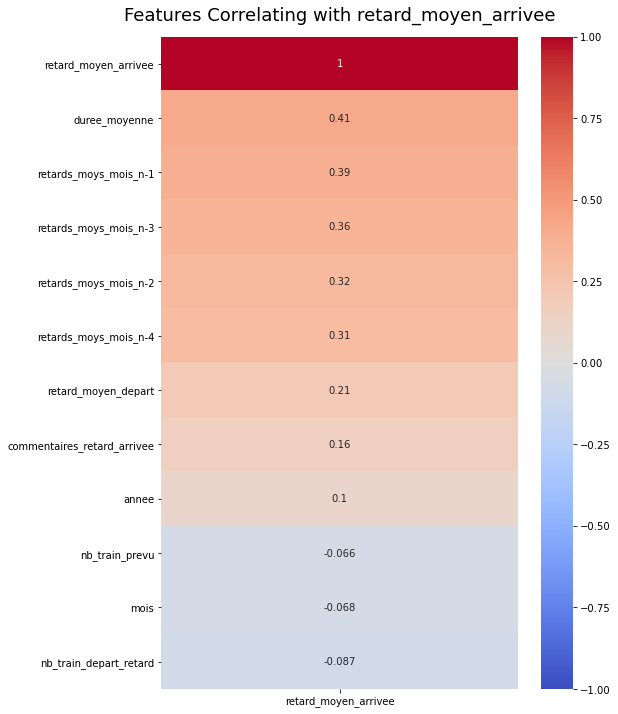

In [46]:
#Observons les correlations entre les features et le donnée que nous cherchons à prédire.

data_f = a[['annee', 'mois','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu','nb_train_depart_retard', 'retard_moyen_depart', 'retards_moys_mois_n-1', 'retards_moys_mois_n-2', 'retards_moys_mois_n-3', 'retards_moys_mois_n-4', 'commentaires_retard_arrivee', 'retard_moyen_arrivee']]


plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data_f.corr()[['retard_moyen_arrivee']].sort_values(by='retard_moyen_arrivee', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Features Correlating with {}'.format('retard_moyen_arrivee'), fontdict={'fontsize':18}, pad=16)

On se rend compte que les features les plus influentes sur le résultat final sont les données sur les retards des mois d'avant. La donnée sur le mois ne compte pas beaucoup donc probablement peu de périodicité des retards. La duree moyenne est la feature la plus importante ce qui parait cohérent. 

Fait étonnant : le mois n-3 est plus corrélé que le mois n-2. 

In [47]:



#On sépare X et y

def transfo_colonnes(a):

     

     X = a[['annee', 'mois','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu','nb_train_depart_retard', 'retard_moyen_depart', 'retards_moys_mois_n-1', 'retards_moys_mois_n-2', 'retards_moys_mois_n-3', 'retards_moys_mois_n-4', 'commentaires_retard_arrivee']]
     y_train = a[a['annee'] <= 2022][['retard_moyen_arrivee']].values.ravel()
     y_test = a[a['annee'] == 2023][['retard_moyen_arrivee']].values.ravel()

     #On commence par le one hot encoding des mois, des gares d'arrivée et de départ. 
     categorical_features = ["mois", "annee", "gare_depart", "gare_arrivee", "service", "commentaires_retard_arrivee"]

     #Les valeurs numériques 
     numeric_features = list(X.drop(["mois", "annee", "gare_depart", "gare_arrivee", "service", "commentaires_retard_arrivee"], axis=1))



     pipeline_traitement_données = ColumnTransformer([
          ('std_scaler', StandardScaler(), numeric_features),
          ('one-hot', OneHotEncoder(), categorical_features)
     ])


     #On recrée un dataframe après la transformation pour pouvoir séparer train et test facilement

     X_transformed = pipeline_traitement_données.fit_transform(X)

     X_train_array = X_transformed.toarray()

     column_names_train = pipeline_traitement_données.get_feature_names_out(input_features=X.columns)


     # Recreate a DataFrame with column names and values
     X_final = pd.DataFrame(X_train_array, columns=column_names_train)

     X_test = X_final[X_final['one-hot__annee_2023']== 1 ]
     X_train = X_final.drop(X_final[X_final['one-hot__annee_2023']== 1].index)

     return [X_train, X_test, y_train, y_test]



In [48]:
#On sépare les dataset d'entrainement et de test. 

output = transfo_colonnes(a)

X_train = output[0]
X_test = output[1]
y_train = output[2]
y_test = output[3]
 

print(X_test)
print(X_train)


      std_scaler__duree_moyenne  std_scaler__nb_train_prevu  \
6908                   0.221884                   -0.610935   
6909                   0.887285                   -0.731446   
6910                  -0.340266                    4.697304   
6911                   0.118632                    0.444974   
6912                  -0.810636                   -0.025594   
...                         ...                         ...   
7629                  -0.638549                    1.351679   
7630                   1.185569                   -0.237923   
7631                  -1.051557                   -0.369912   
7632                  -0.420573                    1.053270   
7633                  -0.030510                    0.158043   

      std_scaler__nb_train_depart_retard  std_scaler__retard_moyen_depart  \
6908                           -0.671105                         0.536325   
6909                           -0.791295                         0.603959   
6910        

On teste un grand nombre de modèles de regression différents et on sort les scores rmse et r2

In [49]:
# Définir une liste de modèles de régression à tester
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('SVR', SVR()),
    ('K-Nearest Neighbors', KNeighborsRegressor())
]


# Créer une matrice pour stocker les erreurs de chaque modèle
results = []

# Définissez une liste de métriques à utiliser
scoring = ['neg_mean_squared_error', 'r2']

# Effectuer la validation croisée pour chaque modèle
for i, (name, model) in enumerate(models):
    # Calculer les erreurs en utilisant la validation croisée
    scores = cross_validate(model, X_train, y_train, cv=5, scoring = scoring)
    
    # Calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
    rmse_norm_scores = np.sqrt(-scores['test_neg_mean_squared_error'])
    
    
    # Stocker le nom du modèle et la moyenne des RMSE
    results.append((name, rmse_norm_scores.mean(), scores['test_r2'].mean()))


print(results)

KeyboardInterrupt: 

On se rend compte que le meilleur résultat est obtenu avec SVR. On sélectionne donc ce modèle pour la suite et on cherche à améliorer ses prédictions en modifiant les hyperparamètres. 

In [ ]:
svr = SVR(gamma=0.1, C= 100)

# Définissez une liste de métriques à utiliser
scoring = ['neg_mean_squared_error', 'r2']

scores = cross_validate(svr, X_train, y_train, cv=5, scoring = scoring)
    
# Calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
rmse_norm_scores = np.sqrt(-scores['test_neg_mean_squared_error'])

print(rmse_norm_scores.mean(), scores['test_r2'].mean())

13.601410205422178 0.1823483788574041


In [ ]:
#On va essayer de trouver les meilleurs hyper paramètres avec une grid search 

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'kernel' : [ 'rbf'],
    'gamma' : [10**i for i in range(-2, 4)],
    'C' : [10**i for i in range(-3, 3)]
}
# Create a based model
sv = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sv, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

# Obtenez les meilleurs hyperparamètres et le modèle optimal
print(grid_search.best_params_)

Le meilleur résultat est obtenu avec C=100 et gamma = 0,01. On utilise SVR avec ces paramètres pour faire une prédiction sur le test set.

In [50]:
svr = SVR(gamma=0.01, C= 100)

svr.fit(X_train,y_train)

# Entraîner le modèle sur l'ensemble d'entraînement
svr.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = svr.predict(X_test)

# Calculer le RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse)


17.411152504335153


On obtient une rmse de 17,41 minutes. Notre modèle n'a donc pas l'air très précis. 

In [51]:
#On compare la valeur retournée par notre modèle à la moyenne du retard 

print(y_test.mean(), np.sqrt(y_test.var()))
print((y_test.max(), y_test.min()))

39.46860678049008 18.89175536336634
(299.6, 0.0)


On se rend compte qu'on est pas très précis (pas vraiment meilleur que le prédicteur "moyenne") mais qu'on peut mitiger cela avec la forte variance des retards et la présence de valeurs extrèmes comme le retard moyen des trains en retard entre tourcoing et Bordeaux en mars 2023.  

Quand on compare ces résultats à ceux obtenus pour la prédiction des retards moyens tous trains confondus (obtenu précédemment), la différence dans la qualité de prédiction parait grande. Cela vient probablement du fait que les trains qui ne sont pas en retard (retard = 0) viennent lisser les valeurs extrêmes. C'est ce qu'on observe pour Tourcoing_Bordeaux en mars 2023. On a retard_moyen_arrivee = 299.3 et retard_moyen_tous_trains_arrivee = 11.61. S'il y a un seul train en retard mais que celui ci est très en retard, on obtient une valeur énorme pour retard_moyen alors que retard_moyen_tous_trains_arrivee est lissé par tous les autres trains qui ne sont pas en retard. 

On pourrait essayer d'améliorer ça en ajoutant un one-hot encoding sur les retards supérieurs ou inférieurs à 100 minutes (Valeur arbitraire pour définir les grands retards). Ceci nous permet de catégoriser les outliers. On ajoutera une feature avec le donnée outlier du mois précédent. 

Changement d'objectif : on prévoit un retard précis jusqu'à 50 min de retard, on dessus, on est juste capable de dire : "votre retard sera supérieur à 50 minutes. Pour estimer notre précision sur cet objectif, on remplace toutes les valeurs prédites supérieures à 50 min par la vrai valeur, si cette vraie valeur est effectivement supérieure à 50 minutes. 

In [53]:
for i in range(len(y_pred)) :
    if y_pred[i] > 45 and y_test[i]> 45:
        y_pred[i] = y_test[i]

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse)

16.85278761326157


In [ ]:
a = add_delays_previous_months(df, 4 )

In [8]:
def add_outlier_previous_months(df, n_months):
    past_month_cols = [f"outlier_ou_non_mois_n-{i}" for i in range(1, n_months+1)]
    for col in past_month_cols:
        df[col] = 0.0
    for i,row in df.iterrows():
        if i%500 == 0:
            print(i)
        annee, mois = row["annee"], row["mois"]
        gare_depart, gare_arrivee = row["gare_depart"], row["gare_arrivee"]
        for j, col_name in enumerate(past_month_cols):
            n_mois_a_soustraire = j+1
            date_mois_prec = (annee, mois-n_mois_a_soustraire) if mois>=n_mois_a_soustraire+1 else ((annee-1, 12+mois-n_mois_a_soustraire) if annee>=2019 else (annee, mois))
            # print((annee, mois), n_mois_a_soustraire, date_mois_prec)
            series = df.loc[(df.gare_depart == gare_depart) & (df.gare_arrivee == gare_arrivee) & (df.annee == date_mois_prec[0]) & (df.mois == date_mois_prec[1]), "outlier"]
            # print(series)
            if not series.empty:
                value = series.values[0]
                # print(value)
                df.loc[i, col_name] = value
            else:
                # un peu brutal de prendre la moyenne totale direct : on pourrait essayer le mois d'avant encore ou l'année d'avant...
                df.loc[i, col_name] = 0
    return df


In [ ]:
data = a.loc[:, ['annee', 'mois', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retards_moys_mois_n-1', 'retards_moys_mois_n-2', 'retards_moys_mois_n-3', 'retards_moys_mois_n-4', 'commentaires_retard_arrivee', 'retard_moyen_arrivee']]

outlier = []

for i in data['retard_moyen_arrivee']:
    if i > 50 : 
        outlier.append(1)
        print(i)
    else:
        outlier.append(0)

data['outlier']= outlier

print(data)

#On ajoute la donnée sur le caractère extrème du retard du mois d'avant

b = add_outlier_previous_months(data, 4)

b = b.drop(b[(b['mois'] == 1) & (b['annee'] == 2018)].index)
b = b.drop(b[(b['mois'] == 2) & (b['annee'] == 2018)].index)
b = b.drop(b[(b['mois'] == 3) & (b['annee'] == 2018)].index)
b = b.drop(b[(b['mois'] == 4) & (b['annee'] == 2018)].index)

print(b)

Text(0.5, 1.0, 'Features Correlating with retard_moyen_arrivee')

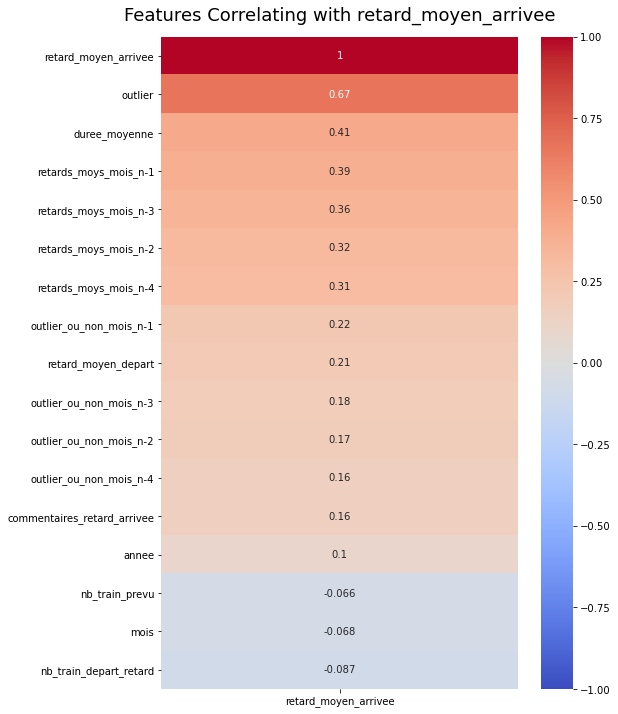

In [38]:


plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(b.corr()[['retard_moyen_arrivee']].sort_values(by='retard_moyen_arrivee', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Features Correlating with {}'.format('retard_moyen_arrivee'), fontdict={'fontsize':18}, pad=16)

In [34]:
pd.reset_option('display.max_rows')
print(b['outlier_ou_non_mois_n-2'])

520     0.0
521     0.0
522     0.0
523     0.0
524     0.0
       ... 
8149    0.0
8150    1.0
8151    0.0
8152    0.0
8153    0.0
Name: outlier_ou_non_mois_n-2, Length: 7634, dtype: float64


In [39]:
#on change transfo colonnes pour effectuer ce changement.



def transfo_colonnes_2(df):
   

    X = df[['annee', 'mois','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu','nb_train_depart_retard', 'retard_moyen_depart', 'retards_moys_mois_n-1', 'retards_moys_mois_n-2', 'retards_moys_mois_n-3', 'retards_moys_mois_n-4', 'commentaires_retard_arrivee', 'outlier_ou_non_mois_n-1', 'outlier_ou_non_mois_n-2', 'outlier_ou_non_mois_n-3', 'outlier_ou_non_mois_n-4']]
    y_train = df[df['annee'] <= 2022][['retard_moyen_arrivee']].values.ravel()
    y_test = df[df['annee'] == 2023][['retard_moyen_arrivee']].values.ravel()

    
    #On commence par le one hot encoding des mois, des gares d'arrivée et de départ. 
    categorical_features = ["mois", "annee", "gare_depart", "gare_arrivee", "service", "commentaires_retard_arrivee", 'outlier_ou_non_mois_n-1', 'outlier_ou_non_mois_n-2', 'outlier_ou_non_mois_n-3', 'outlier_ou_non_mois_n-4']
    #Les valeurs numériques 
    numeric_features = list(X.drop(["mois", "annee", "gare_depart", "gare_arrivee", "service", "commentaires_retard_arrivee", 'outlier_ou_non_mois_n-1', 'outlier_ou_non_mois_n-2', 'outlier_ou_non_mois_n-3', 'outlier_ou_non_mois_n-4'], axis=1))



    pipeline_traitement_données = ColumnTransformer([
        ('std_scaler', StandardScaler(), numeric_features),
        ('one-hot', OneHotEncoder(), categorical_features)
    ])


    #On recrée un dataframe après la transformation pour pouvoir séparer train et test facilement

    X_transformed = pipeline_traitement_données.fit_transform(X)

    X_train_array = X_transformed.toarray()

    column_names_train = pipeline_traitement_données.get_feature_names_out(input_features=X.columns)


    # Recreate a DataFrame with column names and values
    X_final = pd.DataFrame(X_train_array, columns=column_names_train)

    

    X_test = X_final[X_final['one-hot__annee_2023']== 1 ]
    X_train = X_final.drop(X_final[X_final['one-hot__annee_2023']== 1].index)

    return [X_train, X_test, y_train, y_test]



print(transfo_colonnes_2(b))


[      std_scaler__duree_moyenne  std_scaler__nb_train_prevu  \
0                     -0.340266                    3.119179   
1                     -0.340266                    3.371679   
2                      0.646364                   -0.042810   
3                     -0.030510                   -0.214969   
4                     -0.053455                   -0.232185   
...                         ...                         ...   
6903                   1.610049                   -0.398605   
6904                  -0.776219                    3.216736   
6905                   1.782135                   -1.115935   
6906                  -0.627077                    1.891111   
6907                   1.151151                   -0.226446   

      std_scaler__nb_train_depart_retard  std_scaler__retard_moyen_depart  \
0                              -0.550914                         0.257451   
1                               0.192083                         0.329355   
2          

In [40]:
output = transfo_colonnes_2(b)

X_train = output[0]
X_test = output[1]
y_train = output[2]
y_test = output[3]

In [41]:
# Définir une liste de modèles de régression à tester
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('SVR', SVR()),
    ('K-Nearest Neighbors', KNeighborsRegressor())
]


# Créer une matrice pour stocker les erreurs de chaque modèle
results = []

# Définissez une liste de métriques à utiliser
scoring = ['neg_mean_squared_error', 'r2']

# Effectuer la validation croisée pour chaque modèle
for i, (name, model) in enumerate(models):
    # Calculer les erreurs en utilisant la validation croisée
    scores = cross_validate(model, X_train, y_train, cv=5, scoring = scoring)
    
    # Calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
    rmse_norm_scores = np.sqrt(-scores['test_neg_mean_squared_error'])
    
    
    # Stocker le nom du modèle et la moyenne des RMSE
    results.append((name, rmse_norm_scores.mean(), scores['test_r2'].mean()))


print(results)

[('Linear Regression', 309501261976.79047, -2.0071893884763043e+21), ('Ridge', 14.258704958111233, 0.09096626132447434), ('Lasso', 13.483216481905107, 0.20257589374052806), ('ElasticNet', 13.284713545519935, 0.22994249982937104), ('Decision Tree', 17.03329398108542, -0.2862503607178363), ('Random Forest', 13.164202492224055, 0.2386361989082751), ('SVR', 12.501756813065136, 0.31721377335413226), ('K-Nearest Neighbors', 13.380215540374072, 0.2132105954653698)]


In [32]:
svr = SVR(gamma=0.01, C= 100)

svr.fit(X_train,y_train)

# Entraîner le modèle sur l'ensemble d'entraînement
svr.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = svr.predict(X_test)

# Calculer le RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse)


17.508655921960695


Cela empire les résultats. 